In [1]:
import sys
import numpy as np
from scipy import linalg as la, optimize as opt
import matplotlib.pyplot as plt
import proplot as plot
from tqdm import tqdm, trange

sys.path.append('/Users/46h/Research/code/accphys')
from tools.matrix_lattice import fodo
from tools.envelope_analysis import Envelope
from tools import utils
from tools.utils import show
from tools import plotting as myplt

In [2]:
plot.rc['figure.facecolor'] = 'white'

# 4D Beam Covariance Matrix Reconstruction

In this notebook we will use transfer matrices to demonstrate the method outlined in [this paper](https://journals.aps.org/prab/pdf/10.1103/PhysRevSTAB.17.052801) to reconstruct the transverse beam covariance matrix. 

## Method description 

The method uses a wire-scanner at a single location. By wire-scanner, we mean a horizontal, vertical and diagonal wire which can measure the $\langle{x^2}\rangle$, $\langle{y^2}\rangle$, and $\langle{xy}\rangle$ moments. The wire-scanner is located at position $s$, and we want to measure the beam at an upstream location $s_0$. We then vary one or more quadrupoles between $s0$ and $s$, each time measuring the beam dimensions at $s$. 

Assuming no space charge, we know linear transfer matrix $M$ between $s_0$ and $s$. Then we also know the connection between the covariance matrix $\Sigma$ at the two points: $\Sigma_s = M \Sigma_{s_0} M^T$. This gives <br>

$$
\begin{align}
    \langle{x^2}\rangle_s &= 
        M_{11}^2\langle{x^2}\rangle_{s0} 
      + M_{12}^2\langle{x'^2}\rangle_{s0} 
      + 2M_{11}M_{22}\langle{xx'}\rangle_{s0} ,\\
    \langle{y^2}\rangle_s &= 
        M_{33}^2\langle{y^2}\rangle_{s0} 
      + M_{34}^2\langle{y'^2}\rangle_{s0} 
      + 2M_{33}M_{34}\langle{yy'}\rangle_{s0} ,\\
    \langle{xy}\rangle_s &= 
        M_{11}M_{33}\langle{xy}\rangle_{s0} 
      + M_{12}M_{33}\langle{yx'}\rangle_{s0} 
      + M_{11}M_{34}\langle{xy'}\rangle_{s0} 
      + M_{12}M_{34}\langle{x'y'}\rangle_{s0} .
\end{align}
$$

The strategy is to take $N$ measurements, giving the system of equations $\begin{align} \mathbf{A \sigma} = \mathbf{b},\end{align}$ where $\mathbf{b}$ is a vector of the $3N$ measurments, $\mathbf{A}$ is a $3N \times 10$ matrix, and $\mathbf{\sigma}$ is the 10 element vector the beam moments at $s_0$. The system of equations is overdetermined, so we find the least-squares solution for $\mathbf{\sigma}$.

In [3]:
def get_mat(sigma):
    """Return covariance matrix from 10 element moment vector."""
    s11, s22, s12, s33, s44, s34, s13, s23, s14, s24 = sigma
    return np.array([[s11, s12, s13, s14], 
                     [s12, s22, s23, s24], 
                     [s13, s23, s33, s34], 
                     [s14, s24, s34, s44]])

def get_vec(Sigma):
    """Return 10 element moment vector from covariance matrix."""
    s11, s12, s13, s14 = Sigma[0, :]
    s22, s23, s24 = Sigma[1, 1:]
    s33, s34 = Sigma[2, 2:]
    s44 = Sigma[3, 3]
    return np.array([s11, s22, s12, s33, s44, s34, s13, s23, s14, s24])

## Implementation with transfer matrices 

We will create a lattice consisting of: half-drift, focusing quad, drift, defocusing quad, half-drift. The reconstruction point $s_0$ will be at the lattice entrance, and the measurement point $s$ will be at the lattice exit. We will track the envelope of a Danilov distribution without space charge, launching the same beam on each scan but changing the strength of the quadrupoles. First let's create the lattice.

In [4]:
k1, k2 = (0.5, 0.5) # first and second quadrupole strengths
length = 5.0
lattice = fodo(k1, k2, length, start='drift')

Create an envelope matched to this lattice.

In [5]:
env = Envelope(eps=10)
env.match_bare(lattice.M, method='2D')

init_params = np.copy(env.params)
Sigma0 = env.cov()
show(Sigma0, 'Covariance matrix at s0')

Covariance matrix at s0 =
⎡21.008  7.849   0.0     5.0  ⎤
⎢                             ⎥
⎢7.849   4.123   -5.0   3.736 ⎥
⎢                             ⎥
⎢ 0.0    -5.0   21.008  -7.849⎥
⎢                             ⎥
⎣ 5.0    3.736  -7.849  4.123 ⎦


Choose the quadrupole strengths at each scan index.

In [6]:
def get_kvals(kmin, kmax, nscans):
    """Choose quadrupole strengths at each scan index. 
    
    We linearly increase k1 (focusing quad) in the first half of the scan while 
    keeping k2 (defocusing quad) constant. This is flipped in the second half. 
    The strengths are measured in m^-2.
    """
    kavg = (kmin + kmax) / 2
    k1vals, k2vals = np.full(nscans, kavg), np.full(nscans, kavg)
    i = nscans // 2
    linear_scan = np.linspace(kmin, kmax, i)
    k1vals[:i] = linear_scan
    if nscans % 2 != 0:
        i += 1
    k2vals[i:] = linear_scan
    return k1vals, k2vals

Construct $\mathbf{A}$ and $\mathbf{b}$.

In [7]:
def scan(init_params, krange, nscans=3, noise=0.):
    """Take measurements and set up linear system of equations 
    
    The equations take the form Ax = b; we return A and b.
    
    Parameters
    ----------
    krange : (kmin, kmax)
        The minimum and maximum focusing strength.
    nscans : int
        The number of scans to perform.
    noise : float
        Scaling factor for Gaussian noise added to measurements. The Gaussian
        distribution has unit variance. I guess this will have different effects 
        on the different moments, since the units of the moments are not all
        the same.
        
    Returns
    -------
    A, b : ndarray
    Arrays for the equation Ax = b. A has shape (3*nscans, 10) and b has shape (3*nscans,)
    """
    A, b = [], []
    kmin, kmax = krange
    for (k1, k2) in zip(*get_kvals(kmin, kmax, nscans)):
        # Get transfer matrix
        lattice = fodo(k1, k2, length, start='drift')
        M = lattice.M
        A.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
        A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3], 0, 0, 0, 0])
        A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
        # Take measurements
        env.params = np.copy(init_params)
        env.track(lattice.M)
        Sigma = env.cov()
        b.append(Sigma[0, 0])
        b.append(Sigma[2, 2])
        b.append(Sigma[0, 2])
    A, b = np.array(A), np.array(b)
    b += noise * np.random.normal(size=b.shape)
    return A, b

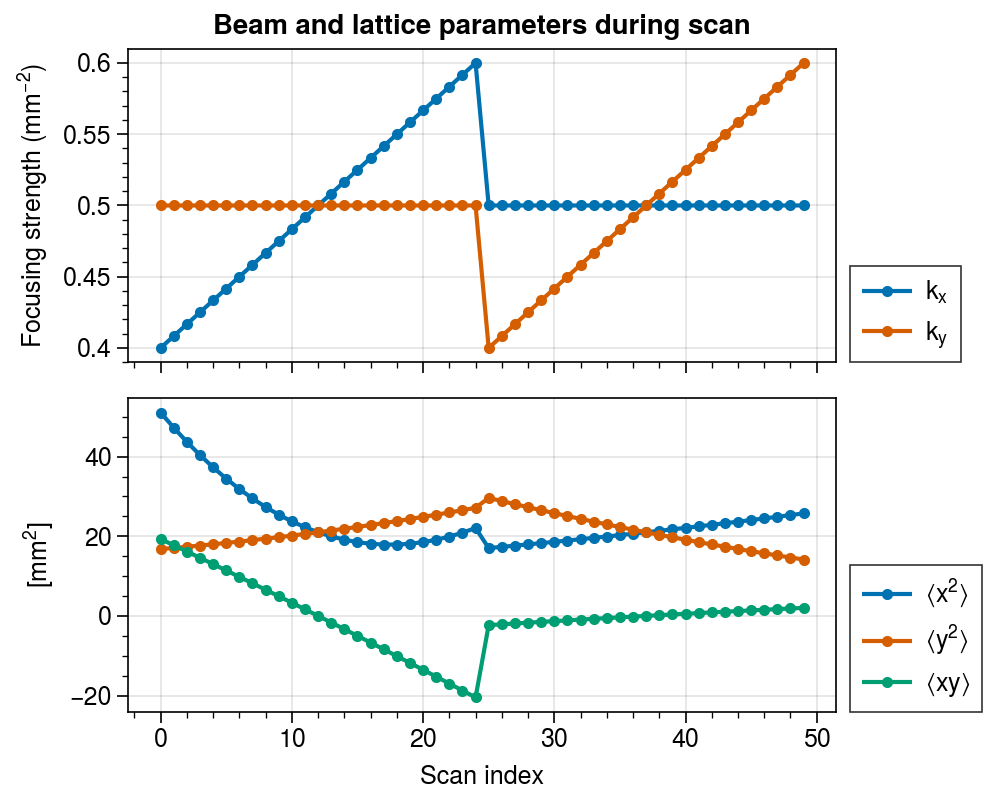

In [8]:
nscans = 50
kmin, kmax = (0.4, 0.6)
A, b = scan(init_params, (kmin, kmax), nscans)

fig, axes = plot.subplots(nrows=2, figsize=(5, 4), spany=False)
k1vals, k2vals = get_kvals(kmin, kmax, nscans)
axes[0].plot(k1vals, marker='.')
axes[0].plot(k2vals, marker='.')
for i in range(3):
    axes[1].plot(b[i::3], marker='.')
axes[0].legend(labels=['$k_x$', '$k_y$'], ncols=1, loc=(1.02, 0))
axes[1].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], ncols=1, loc=(1.02, 0));
axes.format(xlabel='Scan index', toplabels='Beam and lattice parameters during scan')
myplt.set_labels(axes, ['Focusing strength ($mm^{-2}$)', '[$mm^2$]'], 'ylabel')

Compute the least-squares solution to $\mathbf{A\sigma} = \mathbf{b}$.

In [9]:
def solve(A, b, guess=None, disp=True):
    """Reconstruct covariance matrix from measured data."""
    
    def corr_coeffs(sigma):
        x2, xp2, xxp, y2, yp2, yyp, xy, yxp, xyp, xpyp = sigma
        corr = [xxp/np.sqrt(x2*xp2), yyp/np.sqrt(y2*yp2), xy/np.sqrt(x2*y2), yxp/np.sqrt(y2*xp2), xyp/np.sqrt(x2*yp2), xpyp/np.sqrt(xp2*yp2)]
        return corr

    def cost(sigma, A, b):
        return 0.5 * np.sum((np.matmul(A, sigma) - b)**2)

    lb = [0, 0, -np.inf, 0, 0, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf] # squared moments can't be negative
    ub = np.inf
    bounds = opt.Bounds(lb, ub)
    constr = opt.NonlinearConstraint(corr_coeffs, -1, 1)
    if guess is None:
        guess = np.ones(10)
    result = opt.minimize(cost, guess, args=(A, b), 
                          bounds=bounds, constraints=constr, options={'disp':disp})
    return get_mat(result.x)

/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.94118765542281e-07
            Iterations: 53
            Function evaluations: 608
            Gradient evaluations: 53
Sigma - Sigma0 = 
[[ 1.64046610e-05  5.12085246e-06 -4.02008560e-04  3.24135703e-04]
 [ 5.12085246e-06  7.75991285e-07  6.93162133e-04 -2.38864320e-04]
 [-4.02008560e-04  6.93162133e-04  1.70194857e-02 -7.14440156e-03]
 [ 3.24135703e-04 -2.38864320e-04 -7.14440156e-03  2.99385555e-03]]


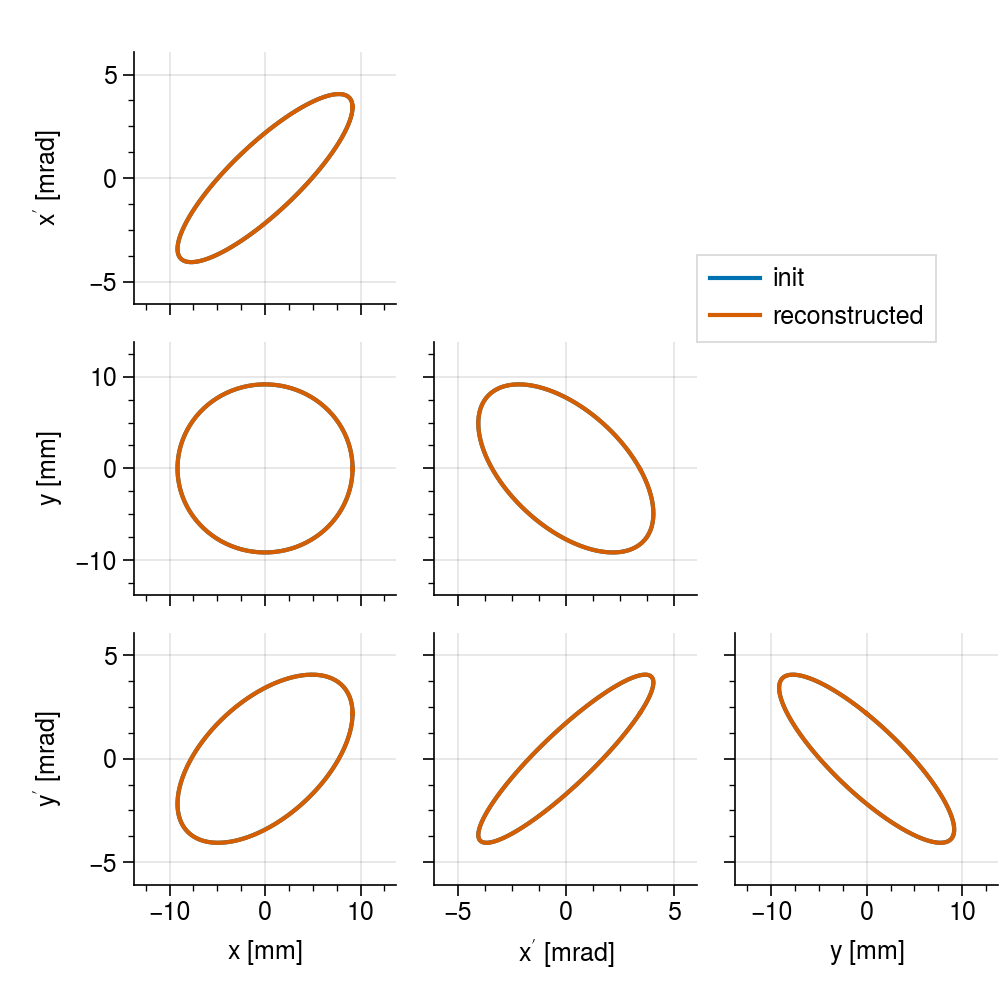

In [10]:
Sigma = solve(A, b)
print('Sigma - Sigma0 = ')
print(Sigma - Sigma0)

env1 = Envelope()
env1.fit_cov(Sigma)
myplt.corner_env([init_params, env1.params], figsize=(5, 5),
                 legend_kws=dict(labels=('init','reconstructed'), loc=(1, 1)));

## Addition of measurement noise

Let's add some Gaussian noise to the measured moments: $\mathbf{b} \rightarrow \mathbf{b} + \mathbf{n}$.

In [13]:
noise_list = np.linspace(0, 0.25, 4) # Gaussian noise factors
nscans_list = np.arange(10, 20) # number of scans to perform at each iteration
errors = np.zeros((len(noise_list), len(nscans_list))) # ssq error for initial vs. final moments
Corr0 = utils.cov2corr(Sigma0)

for j, nscans in enumerate(tqdm(nscans_list)):
    for i, noise in enumerate(noise_list):
        A, b = scan(init_params, (kmin, kmax), nscans, noise)
        Sigma = solve(A, b, guess=get_vec(Sigma0), disp=False)
        errors[i, j] = np.max(np.abs(Sigma - Sigma0))

  0%|          | 0/10 [00:00<?, ?it/s]/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


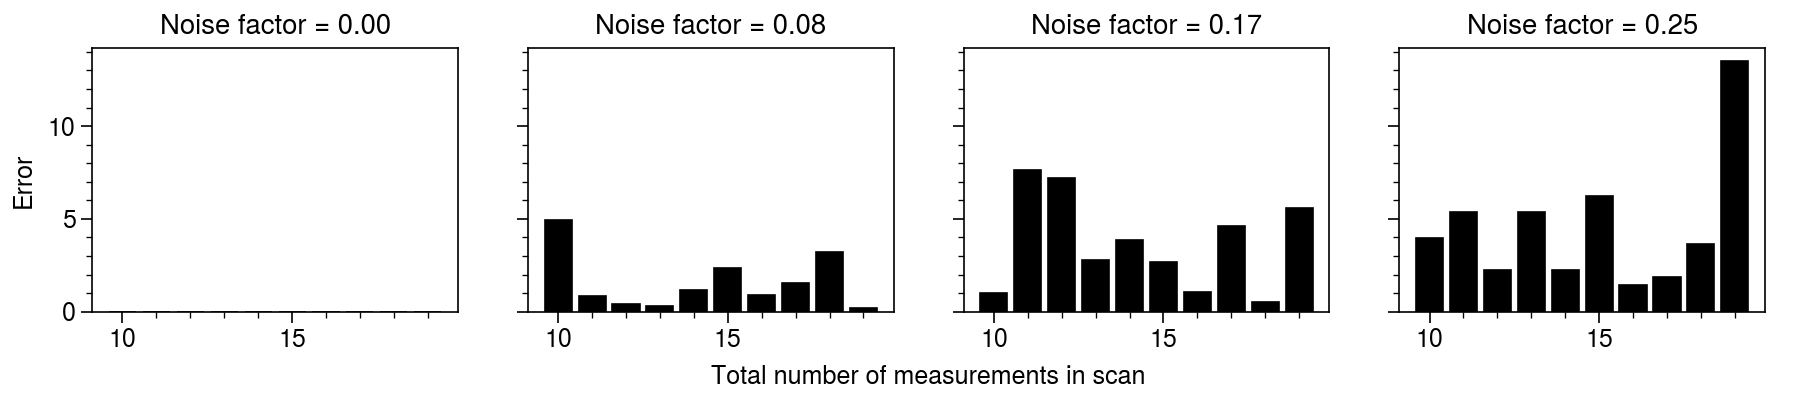

In [14]:
fig, axes = plot.subplots(ncols=len(noise_list), figsize=(9, 2))
for i, ax in enumerate(axes):
    ax.bar(nscans_list, errors[i], color='k')
axes.format(ylabel='Error', xlabel='Total number of measurements in scan', grid=False)
myplt.set_labels(axes, ['Noise factor = {:.2f}'.format(n) for n in noise_list], 'title')